# Misc dataset

In [1]:
B = 3
f = 0.7
Tb = 1000
kb = 0.2
lb = 5
Tt = 10000
kt = 0.4
lt = 10
s = 0.05
std_dev_multiplier = 1
D_red = 10
Tt_red = 10000
kt_red = 0.4
lt_red = 10
s_red = 0.05

In [2]:
from model.graph_mcmc import Graph_MCMC

In [3]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rcParams.update({'text.latex.preamble' : [r'\usepackage{amsmath}']})

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [4]:
graph = Graph_MCMC()
graph.read_from_ns("polbooks")

In [5]:
graph.print_info()
graph.rename_property("label", "_label")

Graph with N=105 nodes, E=441 edges and D=2 vertex features for training


True

In [6]:

graph.convert_props_to_flags()

In [7]:
graph.list_props()

name            (graph)   (type: string, val: polbooks)
description     (graph)   (type: string, val: A network of books about U.S.
                                              politics published close to the
                                              2004 U.S. presidential election,
                                              and sold by Amazon.com. Edges
                                              between books represent frequent
                                              copurchasing of those books by
                                              the same buyers. The network was
                                              compiled by V. Krebs and is
                                              unpublished.)
citation        (graph)   (type: string, val: ['V. Krebs, unpublished,
                                              http://www.orgnet.com/,
                                              http://www.orgnet.com/'])
url             (graph)   (type: string, val: http://

In [8]:
graph.partition(B_min=B, B_max=B)

Performing inference...
Current bracket: (3, 3, 3) (1250.1312900298985, 1250.1312900298985, 1250.1312900298985)
Current bracket: (3, 3, 3) (1250.1312900298985, 1250.1312900298985, 1250.1312900298985)
Bisect at B = 3 with S = 1250.131290029899
Best result: B = 3, S = 1250.131290029899
Done


<VertexPropertyMap object with value type 'int32_t', for Graph 0x7f1f04af98e0, at 0x7f1e9452e340>

In [9]:
av_dl = graph.mcmc(num_iter=Tb)

100%|██████████| 1000/1000 [00:00<00:00, 3694.77it/s]


Drawing soft partition


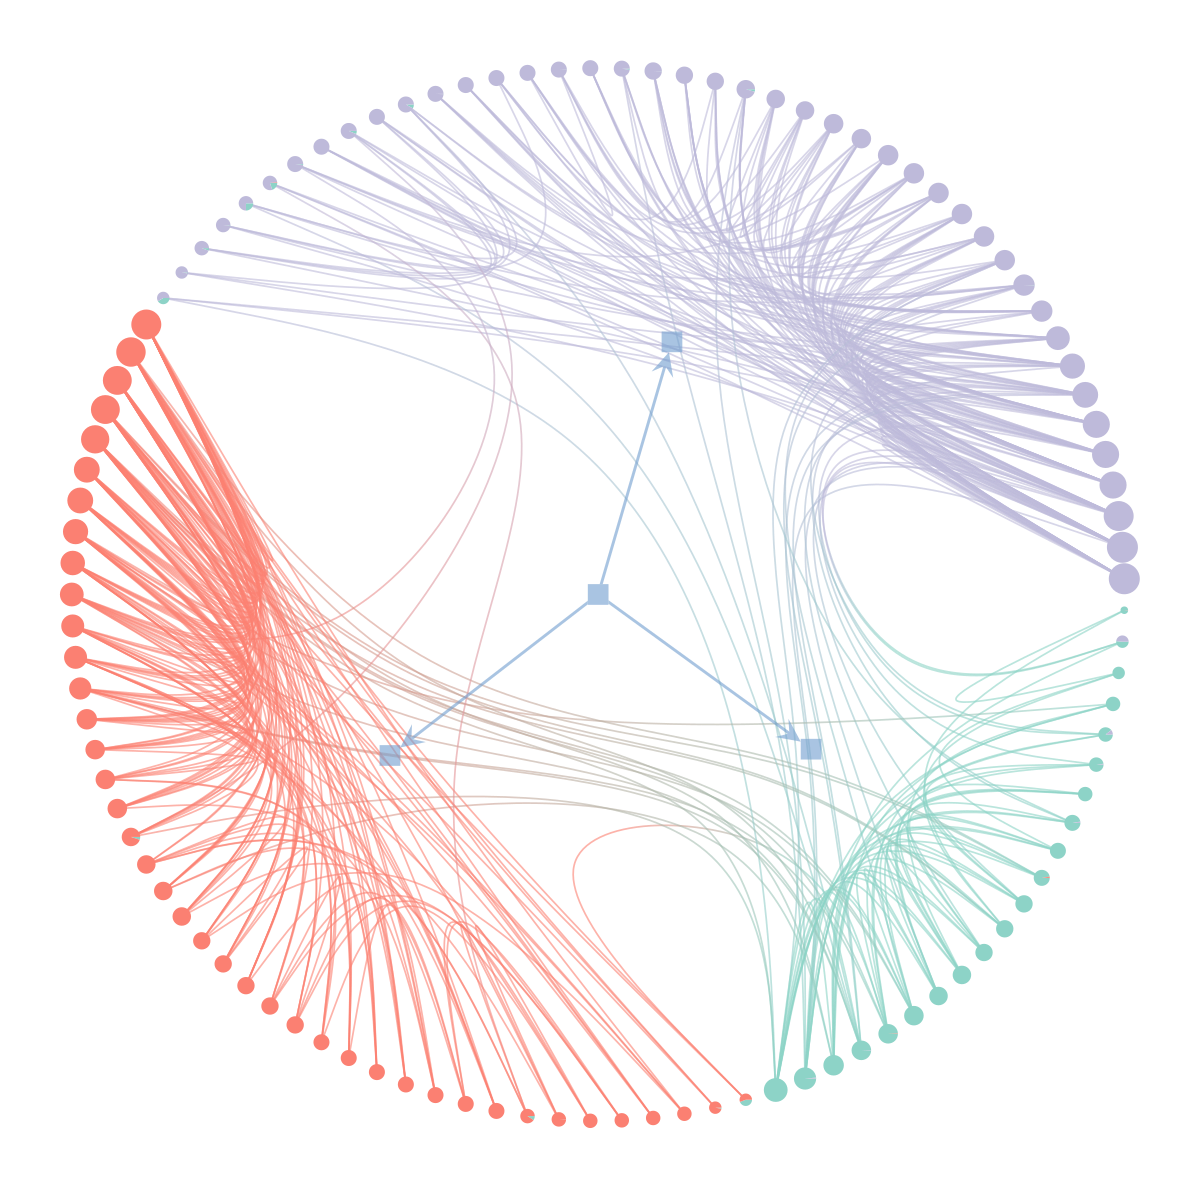

In [10]:
#graph.draw(gen_layout=False, output="polbooks-graph.png")
graph.draw()

Drawing block adjacency matrix $e_{rs}$


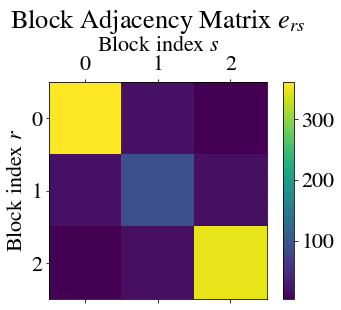

In [11]:
graph.plot_matrix()

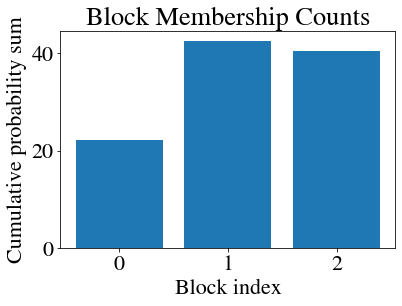

In [12]:
graph.plot_posterior_props()

## Train classifier

In [13]:
from inference.softmax import SoftmaxNeuralNet
import numpy as np

In [14]:
X = graph.generate_feature_matrix()
Y = graph.generate_posterior()

D = X.shape[1]

N = X.shape[0]
assert N == Y.shape[0]



In [15]:
from utils.subsampling import random_index_arr

train_indices, test_indices = random_index_arr(N, fraction=f)
X_train, Y_train = X[train_indices, :], Y[train_indices, :]
X_test, Y_test = X[test_indices, :], Y[test_indices, :]

In [16]:
classifier = SoftmaxNeuralNet(layers_size=[D, B])
classifier.perform_mala(X_train, Y_train, step_scaling=s, num_iter=Tt, verbose=True)

100%|██████████| 10000/10000 [00:04<00:00, 2111.11it/s]Sample accept ratio: 94.69999999999999%
Train. set accuracy: 78.08219178082192%



(0.947, 0.7808219178082192)

## Interpret results

### Thinning

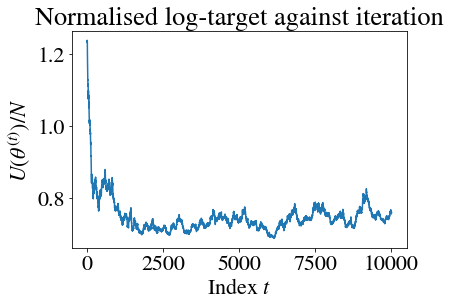

0.746870346794177

In [17]:
classifier.plot_U()

In [18]:
classifier.thin_samples(burn_in=kt, thin_factor=lt)

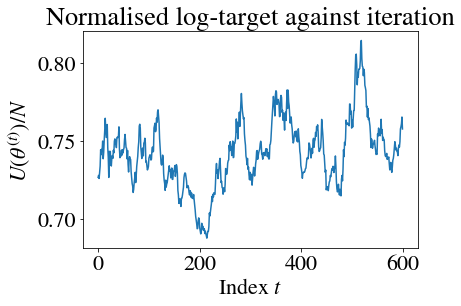

0.7422262071460038


In [19]:
u_mean = classifier.plot_U()
print(u_mean)

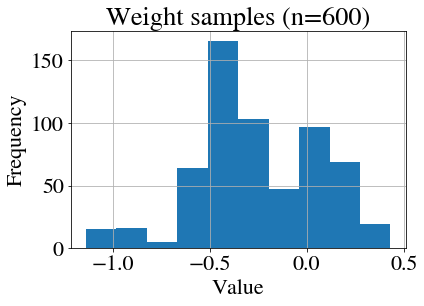

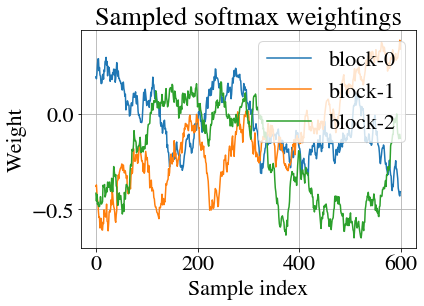

In [20]:
classifier.plot_sample_histogram()
classifier.plot_sample_history()

### Performance

In [21]:
training_loss = classifier.average_loss_per_point(X_train, Y_train, include_prior=False)
test_loss = classifier.average_loss_per_point(X_test, Y_test, include_prior=False)

print("Training loss: {}, Test loss: {}".format(training_loss, test_loss))


Training loss: 0.5710606588304393, Test loss: 0.5822958593748755


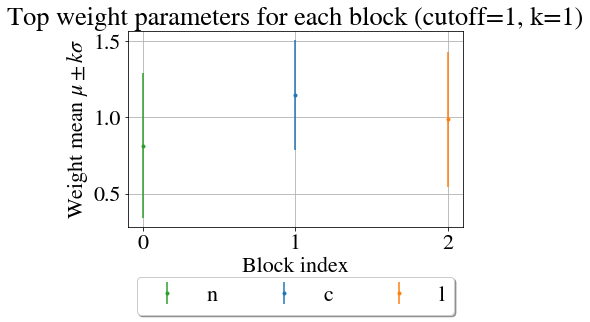

In [22]:
names = list(graph.get_feature_names())
classifier.plot_block_principal_dims(names, cutoff=1, legend=True)

Max cutoff: 0.34197817078340387
Discarded 1 features


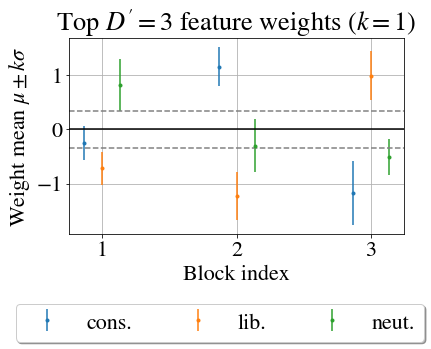

In [23]:
names = list(graph.get_feature_names())
names = ["cons.", "lib.", "neut."]
kept_features = classifier.plot_sampled_weights(names, std_dev_multiplier=std_dev_multiplier, legend=True, D_reduced=D_red)

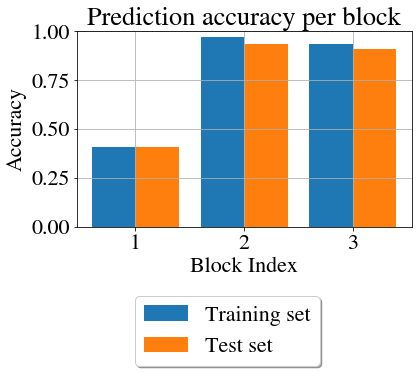

In [24]:
classifier.plot_accuracy_per_class(X_train, Y_train, X_test, Y_test)

In [25]:
classifier.accuracy_per_class(X_train, Y_train)
classifier.accuracy_per_class(X_test, Y_test)

array([0.40928571, 0.93178571, 0.90909091])

In [26]:
reduced_X_train, reduced_X_test = X_train[:, kept_features], X_test[:, kept_features]

reduced_D = reduced_X_train.shape[1]

# nwo train new classifier
reduced_classifier = SoftmaxNeuralNet(layers_size=[reduced_D, B])
reduced_classifier.perform_mala(reduced_X_train, Y_train, step_scaling=s_red, num_iter=Tt, verbose=True)

100%|██████████| 10000/10000 [00:05<00:00, 1918.57it/s]Sample accept ratio: 94.91000000000001%
Train. set accuracy: 84.93150684931507%



(0.9491, 0.8493150684931506)

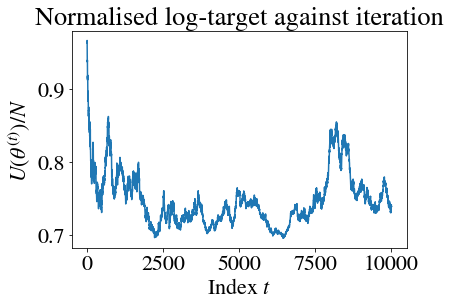

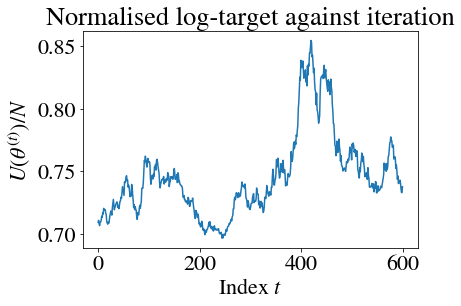

0.7460713752467505

In [27]:
reduced_classifier.plot_U()
reduced_classifier.thin_samples(burn_in=kt_red, thin_factor=lt_red)
reduced_classifier.plot_U()

In [28]:
reduced_training_loss = reduced_classifier.average_loss_per_point(reduced_X_train, Y_train, include_prior=False)
reduced_test_loss = reduced_classifier.average_loss_per_point(reduced_X_test, Y_test, include_prior=False)

print("REDUCED CLASSIFIER -- Training loss: {}, Test loss: {}".format(reduced_training_loss, reduced_test_loss))

REDUCED CLASSIFIER -- Training loss: 0.5624487227606336, Test loss: 0.6007032984905071


In [29]:
print("Average description length per entity: {}".format(av_dl))
print("Training loss: {}, Test loss: {}".format(training_loss, test_loss))
print("D': {}".format(len(kept_features)))
print("REDUCED CLASSIFIER -- Training loss: {}, Test loss: {}".format(reduced_training_loss, reduced_test_loss))

Average description length per entity: 2.2499418604185126
Training loss: 0.5710606588304393, Test loss: 0.5822958593748755
D': 3
REDUCED CLASSIFIER -- Training loss: 0.5624487227606336, Test loss: 0.6007032984905071
